<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Objectives" data-toc-modified-id="Objectives-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Objectives</a></span><ul class="toc-item"><li><span><a href="#Lines-to-overload" data-toc-modified-id="Lines-to-overload-0.1.1"><span class="toc-item-num">0.1.1&nbsp;&nbsp;</span>Lines to overload</a></span></li><li><span><a href="#Quick-contextual-info" data-toc-modified-id="Quick-contextual-info-0.1.2"><span class="toc-item-num">0.1.2&nbsp;&nbsp;</span>Quick contextual info</a></span></li></ul></li></ul></li><li><span><a href="#Définition-des-IST" data-toc-modified-id="Définition-des-IST-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Définition des IST</a></span></li><li><span><a href="#Analyse-sur-la-grille-de-base-sans-modifications-topologiques" data-toc-modified-id="Analyse-sur-la-grille-de-base-sans-modifications-topologiques-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analyse sur la grille de base sans modifications topologiques</a></span></li><li><span><a href="#Check-the-calibration" data-toc-modified-id="Check-the-calibration-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Check the calibration</a></span></li><li><span><a href="#Generate-best-agent-and-overload-dataframe" data-toc-modified-id="Generate-best-agent-and-overload-dataframe-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Generate best agent and overload dataframe</a></span><ul class="toc-item"><li><span><a href="#ligther-df_analysis" data-toc-modified-id="ligther-df_analysis-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>ligther df_analysis</a></span></li><li><span><a href="#best_agent-overload-info" data-toc-modified-id="best_agent-overload-info-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>best_agent overload info</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#check-that-scenarios-are-continuous-in-the-indices-of-the-resultating-dataframe.-Otherwise-reorder" data-toc-modified-id="check-that-scenarios-are-continuous-in-the-indices-of-the-resultating-dataframe.-Otherwise-reorder-4.2.0.1"><span class="toc-item-num">4.2.0.1&nbsp;&nbsp;</span>check that scenarios are continuous in the indices of the resultating dataframe. Otherwise reorder</a></span></li></ul></li></ul></li></ul></li></ul></div>

In [58]:
import os
import re
import csv
import numpy as np
import warnings
import pandas as pd
import fastparquet
import grid2op
import cufflinks as cf
from grid2op.PlotGrid import PlotMatplot
import pyarrow #necessary for saving dataframe in feather format
from grid2op.Parameters import Parameters
from grid2op.Chronics import Multifolder, GridStateFromFileWithForecasts
from lightsim2grid import LightSimBackend
from tqdm.notebook import tqdm
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
#from grid2op.PlotGrid import PlotMatplot
from grid2op.PlotGrid import NUKE_COLOR, THERMAL_COLOR, HYDRO_COLOR, SOLAR_COLOR, WIND_COLOR
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#from itables import init_notebook_mode
#init_notebook_mode(all_interactive=True)

import ipywidgets as widgets
from ipywidgets import Layout

import warnings
warnings.filterwarnings('ignore')

In [59]:
grid2op_data_folder = os.path.realpath("..//..//data_grid2op")
env_name = "l2rpn_idf_2023_v4_20pc"#"l2rpn_idf_2023_v6_x30"


overload_time_percentage=1    # percentage of time an overloaded line is in overload 
high_voltage_threshold=250    # Difference between THT vs HT lines: THT lines are already big, no need to get a lot more margin
#When computed on max flow
#MarginFactor_HighVoltage=1.3#1.2 #margin factor for lines not overloaded. 
#MarginFactor_LowVoltage=1.5#1.4

# when computed on 99 percentile
MarginFactor_HighVoltage = 2.0
MarginFactor_LowVoltage  = 2.5

# cf computation in MakeLimits.ipynb
# voltage_threshold = 250
# be careful with definition of votage level below: 1.0 if low_votage and 0.0 if high voltage
# voltage_level = np.array([1. * any([k < voltage_threshold for k in item]) for item in zip(env.backend.v_or, env.backend.v_or)])
# tmp_ = np.percentile(res_aor, q=99., axis=0) * (2. + 0.1 * voltage_level)  # 1.8 to have no overload, so I add more


output_folder="Outputs"#f"Outputs/Outputs_{env_name}"#TO DO: mettre en cohérence
v_calibration="v0"

input_file_flow="FlowDataset.parquet"
input_file_ov_lines="lines_to_overload.csv"#the lines that were choosen to be overloaded

output_file_th="thermal_limits.csv"
output_file_flow_light="FlowDataset_light.file"
output_file_ov_df='Overloads_info_Best_Agent.file'


In [60]:
output_folder_v_calibration=f"{output_folder}/{env_name}/{v_calibration}"

if not os.path.exists(output_folder_v_calibration):
    os.makedirs(output_folder_v_calibration)

#check that inputs exist
input_file_flow_path=os.path.join(output_folder_v_calibration,input_file_flow)
if not os.path.exists(input_file_flow_path):
    print("have you generated FlowDataset ? it cannont be found in "+input_file_flow_path)
    print("you might want to run previous notebook")
    raise
    
input_file_ov_lines_path=os.path.join(output_folder_v_calibration,input_file_ov_lines)
if not os.path.exists(input_file_ov_lines_path):
    print("have you choosen the lines to overload ? it cannont be found in "+input_file_ov_lines_path)
    print("you might want to run previous notebook")
    raise

In [61]:
path_env = os.path.join(grid2op_data_folder,f"{env_name}")#f"../generation_donnees/{env_name}"

params = Parameters()
params.NO_OVERFLOW_DISCONNECTION = True
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    
    env = grid2op.make(env_name,
                   #chronics_path=path_chronix,
                   param=params,
                   backend=LightSimBackend(),
                   chronics_class=Multifolder,
                   data_feeding_kwargs={"gridvalueClass": GridStateFromFileWithForecasts}
                   )

LINE_NAMES = env.name_line
GEN_NAMES = ["_".join([a,b]) for a,b in zip(env.name_gen,env.gen_type)]
GENTYPE_SET = set(env.gen_type)


In [62]:

df = pd.read_parquet(input_file_flow_path, engine='fastparquet')

if "action_before_start" in df.columns:
    df.rename(columns={'action_before_start':'agent'}, inplace=True)
#from fastparquet import ParquetFile
#pf = ParquetFile(flows_outputs,)
#df = pf.to_pandas()

In [63]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16069334 entries, 0 to 16069333
Columns: 203 entries, 0_1_0 to agent
dtypes: datetime64[ns](1), float32(195), int32(5), object(2)
memory usage: 12.3+ GB


In [64]:
df.tail()

,0_1_0,0_2_1,10_11_2,69_70_3,23_71_4,70_71_5,70_72_6,69_73_7,69_74_8,68_74_9,73_74_10,75_76_11,68_76_12,1_11_13,74_76_14,76_77_15,77_78_16,76_79_17,76_79_18,78_79_19,76_81_20,81_82_21,82_83_22,82_84_23,2_11_24,83_84_25,84_85_26,84_87_27,84_88_28,87_88_29,88_89_30,88_89_31,89_90_32,88_91_33,88_91_34,6_11_35,90_91_36,91_92_37,91_93_38,92_93_39,93_94_40,79_95_41,81_95_42,93_95_43,79_96_44,79_97_45,10_12_46,79_98_47,91_99_48,93_99_49,94_95_50,95_96_51,97_99_52,98_99_53,99_100_54,91_101_55,100_101_56,11_13_57,99_102_58,99_103_59,102_103_60,102_104_61,99_105_62,103_104_63,104_105_64,104_106_65,104_107_66,105_106_67,12_14_68,107_108_69,102_109_70,108_109_71,109_110_72,109_111_73,16_112_74,31_112_75,31_113_76,26_114_77,113_114_78,13_14_79,11_116_80,74_117_81,75_117_82,11_15_83,14_16_84,3_4_85,15_16_86,16_17_87,17_18_88,18_19_89,14_18_90,19_20_91,20_21_92,21_22_93,22_23_94,22_24_95,2_4_96,24_26_97,26_27_98,27_28_99,7_29_100,25_29_101,16_30_102,28_30_103,22_31_104,30_31_105,26_31_106,4_5_107,14_32_108,18_33_109,34_35_110,34_36_111,32_36_112,33_35_113,33_36_114,36_38_115,36_39_116,29_37_117,5_6_118,38_39_119,39_40_120,39_41_121,40_41_122,42_43_123,33_42_124,43_44_125,44_45_126,45_46_127,45_47_128,7_8_129,46_48_130,41_48_131,41_48_132,44_48_133,47_48_134,48_49_135,48_50_136,50_51_137,51_52_138,52_53_139,8_9_140,48_53_141,48_53_142,53_54_143,53_55_144,54_55_145,55_56_146,49_56_147,55_57_148,50_57_149,53_58_150,3_10_151,55_58_152,55_58_153,54_58_154,58_59_155,58_60_156,59_60_157,59_61_158,60_61_159,62_63_160,37_64_161,4_10_162,63_64_163,48_65_164,48_65_165,61_65_166,61_66_167,65_66_168,46_68_169,48_68_170,68_69_171,23_69_172,7_4_173,25_24_174,80_79_175,86_85_176,115_67_177,29_16_178,37_36_179,62_58_180,63_60_181,64_65_182,64_67_183,67_68_184,80_67_185,wind,nuclear,solar,hydro,thermal,wind_w,wind_ne,wind_se,load,datetimes,hour_of_day,month,year,day_of_year,day_of_week,scenario,agent
16069329,108.0,194.0,232.0,178.0,237.0,191.0,19.0,215.0,186.0,314.0,130.0,16.0,578.0,192.0,119.0,236.0,61.0,25.0,12.0,57.0,382.0,358.0,72.0,76.0,103.0,54.0,170.0,103.0,140.0,317.0,120.0,228.0,205.0,525.0,164.0,182.0,238.0,197.0,154.0,109.0,257.0,170.0,125.0,81.0,193.0,280.0,105.0,250.0,38.0,311.0,98.0,153.0,209.0,193.0,82.0,133.0,98.0,33.0,91.0,13.0,35.0,63.0,92.0,306.0,200.0,64.0,125.0,56.0,68.0,133.0,85.0,158.0,546.0,163.0,1364.0,290.0,59.0,128.0,58.0,68.0,77.0,257.0,228.0,116.0,619.0,271.0,188.0,342.0,289.0,108.0,97.0,32.0,53.0,96.0,489.0,614.0,309.0,305.0,148.0,72.0,117.0,272.0,184.0,64.0,4.0,87.0,145.0,385.0,149.0,125.0,19.0,113.0,107.0,79.0,375.0,92.0,66.0,356.0,194.0,38.0,138.0,78.0,64.0,122.0,163.0,87.0,74.0,37.0,31.0,208.0,88.0,113.0,113.0,62.0,76.0,123.0,153.0,68.0,37.0,50.0,40.0,102.0,101.0,5.0,32.0,28.0,64.0,91.0,43.0,57.0,99.0,298.0,85.0,89.0,106.0,254.0,240.0,55.0,57.0,64.0,226.0,231.0,328.0,121.0,211.0,211.0,47.0,72.0,23.0,29.0,17.0,112.0,221.0,512.0,381.0,538.0,40.0,306.0,134.0,244.0,226.0,124.0,366.0,563.0,674.0,538.0,529.0,1600.0,0.0,665.0,690.0,180.0,196.0,128.0,3418.0,2035-12-30 23:40:00,23,12,2035,364,6,2035-12-24_4,sub_99_112212221122
16069330,108.0,195.0,243.0,177.0,236.0,190.0,19.0,215.0,185.0,314.0,130.0,17.0,575.0,192.0,118.0,236.0,60.0,24.0,11.0,58.0,380.0,358.0,72.0,75.0,103.0,54.0,171.0,104.0,140.0,319.0,120.0,228.0,205.0,525.0,164.0,185.0,238.0,197.0,155.0,109.0,258.0,170.0,126.0,84.0,193.0,276.0,103.0,246.0,37.0,313.0,96.0,153.0,204.0,189.0,82.0,132.0,97.0,39.0,88.0,12.0,35.0,62.0,91.0,306.0,200.0,64.0,126.0,56.0,72.0,134.0,87.0,159.0,547.0,161.0,1385.0,291.0,59.0,128.0,57.0,75.0,76.0,256.0,227.0,124.0,625.0,277.0,196.0,344.0,290.0,108.0,94.0,32.0,54.0,97.0,487.0,612.0,311.0,303.0,148.0,72.0,110.0,274.0,182.0,64.0,3.0,88.0,144.0,391.0,148.0,124.0,19.0,113.0,106.0,79.0,375.0,92.0,66.0,354.0,198.0,38.0,136.0,77.0,63.0,122.0,162.0,86.0,74.0,38.0,31.0,209.0,88.0,112.0,112.0,62.0,76.0,124.0,154.0,68.0,37.0,50.0,40.0,102.0,101.0,5.0,32.0,28.0,64.0,91.0,43.0,58.0,99.0,301.0,85.0,89.0,105.0,254.0,240.0,55.0,57.0,66.0,226.0,229.0,333.0,122.0

In [65]:
old_ist = env.backend.get_thermal_limit()
print(f'the thermal limits are:{old_ist}')

the thermal limits are:[ 233.4  354.4  792.7  550.2  572.2  557.2    8.   480.   567.4  681.8
  357.6  336.9  819.   419.2  304.2  626.2  256.1  300.1  132.7  165.9
  841.  1105.5  428.2  555.2  224.2  374.4  285.6  429.8  253.1  479.6
  238.3  452.6  312.9  627.8  196.1  360.9  317.1  325.1  352.6  347.3
  565.5  495.7 1422.9  479.8  646.9 1603.9  364.1 1498.4  278.   866.2
 1667.7  569.6 1350.2 1478.   380.8  282.4  246.9  301.3  766.9  401.2
  306.9  314.4  333.4  748.9  513.4  255.8  513.   268.5  219.   492.
  420.4  417.4  637.8  571.9  593.8  273.7  247.   385.3  283.4  251.2
  210.8  473.9  408.5  162.7  602.2 1098.6  205.   546.   435.9  191.4
  424.1  106.2  149.2  184.9 1146.1 1117.8  569.6  800.2  380.3  292.1
  636.5  487.5  490.9  207.4  590.6  243.8  466.   698.2  385.   351.7
   60.9  231.9  340.8  212.8  749.2  332.4  348.   798.   398.3  414.4
  341.1  371.4  401.2  298.3  343.3  267.8  213.9  160.8  112.2  458.9
  349.7  489.   489.   180.7  196.7  191.9  238.4  174.

## Objectives
you expect those lines to be overloaded 2% of the year



### Lines to overload

In [66]:
separator=","
with open(input_file_ov_lines_path, "r") as f:
    csv_reader=csv.reader(f, delimiter=separator)
    lines_to_overload = [row[0] for row in csv_reader]

print("lines overloaded")    
lines_to_overload

lines overloaded


['68_76_12',
 '76_79_17',
 '76_79_18',
 '91_92_37',
 '92_93_39',
 '79_95_41',
 '93_95_43',
 '102_103_60',
 '31_112_75',
 '11_15_83',
 '15_16_86',
 '17_18_88',
 '21_22_93',
 '26_31_106',
 '45_46_127',
 '48_49_135',
 '48_50_136',
 '55_56_146',
 '49_56_147',
 '55_57_148',
 '50_57_149',
 '54_58_154',
 '4_10_162',
 '61_65_166',
 '43_44_125']

In [67]:
#Criteriae
threshold_interesting_overload_duration=10 #10 time steps
threshold_hard_overload_duration=25

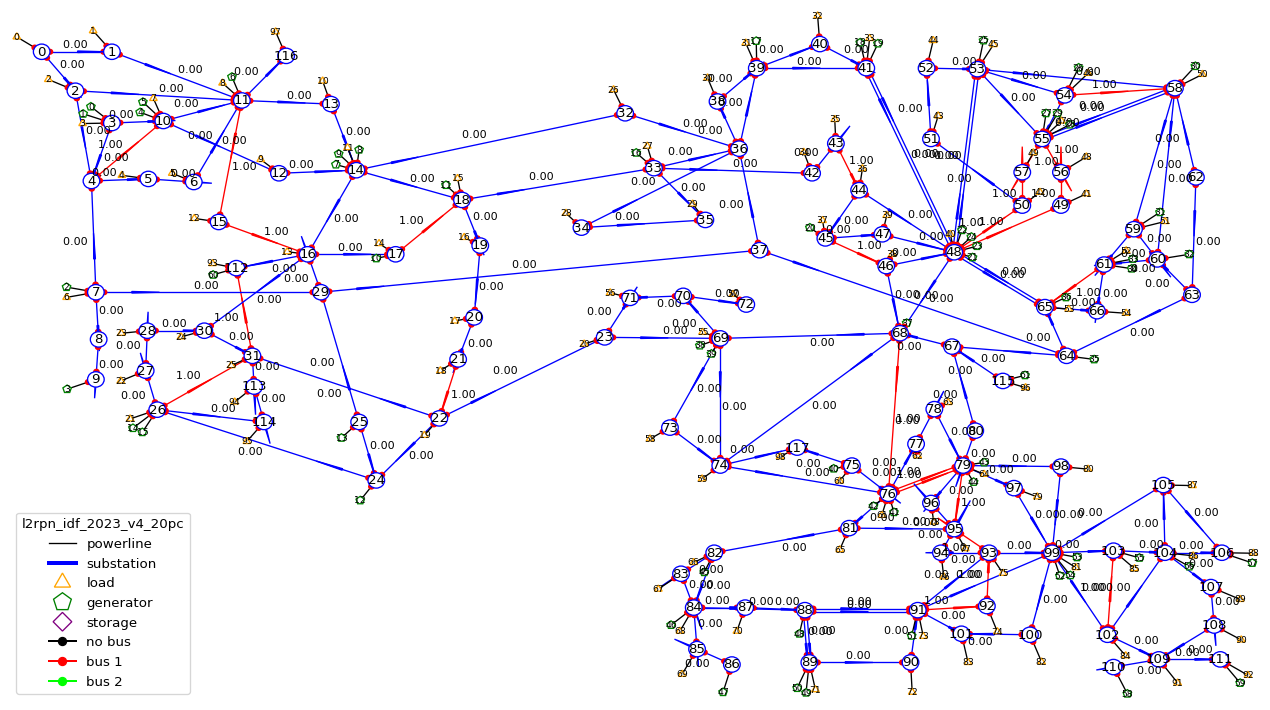

In [68]:
#lines to be overloaded
from grid2op.PlotGrid import PlotMatplot
import plotly.graph_objects as go

plot_helper = PlotMatplot(env.observation_space)
plot_helper._line_arrow_width = 3
plot_helper._line_arrow_len = 50

name_line_list=list(env.name_line)
proposed_overloads=[name_line_list.index(l) for l in lines_to_overload]

l_info = np.zeros(env.n_line)
l_info[proposed_overloads] =1.0#overloads_lines_df.values
_ = plot_helper.plot_info(line_values=l_info, coloring="line")



### Quick contextual info

<Axes: >

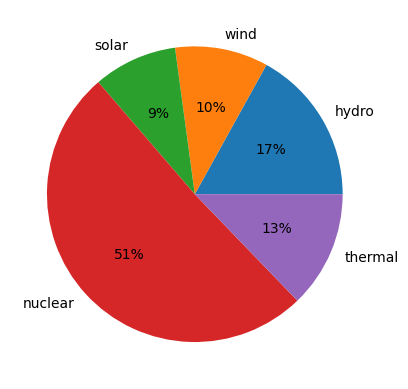

In [69]:
mix_df=df[["hydro","wind","solar","nuclear","thermal"]].sum(axis=0)
mix_df.plot.pie(autopct='%1.0f%%')

Text(0.5, 1.0, 'nb scenarios per month')

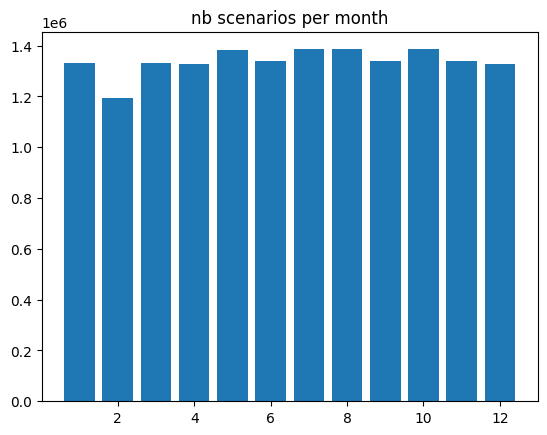

In [70]:
months, nb_m = np.unique(df[["month"]].values, return_counts=True)
plt.bar(months, height = nb_m)
plt.title("nb scenarios per month")

# Définition des IST

On va caler les limites thermiques sur la base des monotones des lignes que l'on souhaite voir surchargées

Good To know: On average 30% of the line on the french grid can be seen overloaded for 1% of the time

In [71]:
df_donothing = df.loc[df.agent == 'do_nothing'] #TO DO: mettre en cohérence avec nom de colonne "agent"
df_donothing.describe()

,0_1_0,0_2_1,10_11_2,69_70_3,23_71_4,70_71_5,70_72_6,69_73_7,69_74_8,68_74_9,73_74_10,75_76_11,68_76_12,1_11_13,74_76_14,76_77_15,77_78_16,76_79_17,76_79_18,78_79_19,76_81_20,81_82_21,82_83_22,82_84_23,2_11_24,83_84_25,84_85_26,84_87_27,84_88_28,87_88_29,88_89_30,88_89_31,89_90_32,88_91_33,88_91_34,6_11_35,90_91_36,91_92_37,91_93_38,92_93_39,93_94_40,79_95_41,81_95_42,93_95_43,79_96_44,79_97_45,10_12_46,79_98_47,91_99_48,93_99_49,94_95_50,95_96_51,97_99_52,98_99_53,99_100_54,91_101_55,100_101_56,11_13_57,99_102_58,99_103_59,102_103_60,102_104_61,99_105_62,103_104_63,104_105_64,104_106_65,104_107_66,105_106_67,12_14_68,107_108_69,102_109_70,108_109_71,109_110_72,109_111_73,16_112_74,31_112_75,31_113_76,26_114_77,113_114_78,13_14_79,11_116_80,74_117_81,75_117_82,11_15_83,14_16_84,3_4_85,15_16_86,16_17_87,17_18_88,18_19_89,14_18_90,19_20_91,20_21_92,21_22_93,22_23_94,22_24_95,2_4_96,24_26_97,26_27_98,27_28_99,7_29_100,25_29_101,16_30_102,28_30_103,22_31_104,30_31_105,26_31_106,4_5_107,14_32_108,18_33_109,34_35_110,34_36_111,32_36_112,33_35_113,33_36_114,36_38_115,36_39_116,29_37_117,5_6_118,38_39_119,39_40_120,39_41_121,40_41_122,42_43_123,33_42_124,43_44_125,44_45_126,45_46_127,45_47_128,7_8_129,46_48_130,41_48_131,41_48_132,44_48_133,47_48_134,48_49_135,48_50_136,50_51_137,51_52_138,52_53_139,8_9_140,48_53_141,48_53_142,53_54_143,53_55_144,54_55_145,55_56_146,49_56_147,55_57_148,50_57_149,53_58_150,3_10_151,55_58_152,55_58_153,54_58_154,58_59_155,58_60_156,59_60_157,59_61_158,60_61_159,62_63_160,37_64_161,4_10_162,63_64_163,48_65_164,48_65_165,61_65_166,61_66_167,65_66_168,46_68_169,48_68_170,68_69_171,23_69_172,7_4_173,25_24_174,80_79_175,86_85_176,115_67_177,29_16_178,37_36_179,62_58_180,63_60_181,64_65_182,64_67_183,67_68_184,80_67_185,wind,nuclear,solar,hydro,thermal,wind_w,wind_ne,wind_se,load,hour_of_day,month,year,day_of_year,day_of_week
count,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.00000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,52468

In [72]:
df_donothing[LINE_NAMES[proposed_overloads]].head()

,68_76_12,76_79_17,76_79_18,91_92_37,92_93_39,79_95_41,93_95_43,102_103_60,31_112_75,11_15_83,15_16_86,17_18_88,21_22_93,26_31_106,45_46_127,48_49_135,48_50_136,55_56_146,49_56_147,55_57_148,50_57_149,54_58_154,4_10_162,61_65_166,43_44_125
0,310.0,10.0,5.0,94.0,40.0,150.0,16.0,43.0,74.0,56.0,129.0,182.0,126.0,183.0,43.0,99.0,124.0,45.0,69.0,31.0,42.0,87.0,364.0,58.0,15.0
1,327.0,13.0,6.0,94.0,42.0,155.0,16.0,45.0,69.0,53.0,121.0,172.0,129.0,193.0,42.0,100.0,125.0,45.0,70.0,32.0,43.0,86.0,368.0,59.0,15.0
2,330.0,17.0,8.0,93.0,44.0,154.0,14.0,47.0,67.0,53.0,121.0,160.0,134.0,201.0,42.0,105.0,131.0,51.0,75.0,34.0,47.0,87.0,377.0,56.0,15.0
3,332.0,20.0,10.0,92.0,45.0,154.0,13.0,47.0,66.0,53.0,122.0,157.0,136.0,207.0,40.0,110.0,137.0,56.0,80.0,36.0,51.0,88.0,383.0,50.0,18.0
4,335.0,23.0,11.0,90.0,48.0,155.0,15.0,48.0,67.0,53.0,124.0,162.0,136.0,211.0,39.0,113.0,141.0,59.0,83.0,38.0,53.0,91.0,387.0,50.0,22.0


In [73]:
quantile_threshold_ist=overload_time_percentage/100 
selection_ist = df_donothing[LINE_NAMES[proposed_overloads]].quantile(1-quantile_threshold_ist, axis=0).round() + 1
selection_ist

68_76_12      730.0
76_79_17      146.0
76_79_18       69.0
91_92_37      244.0
92_93_39      259.0
79_95_41      398.0
93_95_43      311.0
102_103_60     99.0
31_112_75     423.0
11_15_83      151.0
15_16_86      236.0
17_18_88      397.0
21_22_93      124.0
26_31_106     240.0
45_46_127      68.0
48_49_135     157.0
48_50_136     195.0
55_56_146      90.0
49_56_147     119.0
55_57_148      68.0
50_57_149      79.0
54_58_154     118.0
4_10_162      372.0
61_65_166     100.0
43_44_125     141.0
Name: 0.99, dtype: float64

In [74]:

immuned_lines = list(set(LINE_NAMES).difference(set(LINE_NAMES[proposed_overloads])))
df_donothing[immuned_lines].head()

,95_96_51,29_37_117,50_51_137,73_74_10,2_11_24,60_61_159,22_24_95,41_48_131,40_41_122,62_63_160,10_12_46,91_101_55,69_73_7,99_103_59,55_58_153,82_83_22,104_107_66,61_66_167,3_10_151,74_76_14,6_11_35,74_117_81,27_28_99,68_74_9,25_29_101,44_48_133,102_109_70,98_99_53,75_117_82,79_98_47,54_55_145,109_110_72,23_69_172,11_13_57,5_6_118,58_60_156,52_53_139,8_9_140,76_81_20,22_31_104,39_41_121,36_39_116,88_91_34,99_102_58,48_53_142,48_65_165,93_99_49,103_104_63,70_71_5,91_93_38,91_99_48,31_113_76,105_106_67,84_85_26,22_23_94,51_52_138,80_67_185,69_70_3,67_68_184,83_84_25,3_4_85,19_20_91,12_14_68,94_95_50,89_90_32,46_48_130,36_38_115,0_2_1,7_8_129,64_65_182,100_101_56,11_116_80,84_87_27,2_4_96,93_94_40,75_76_11,33_42_124,0_1_0,47_48_134,46_68_169,63_64_163,59_61_158,88_89_30,26_27_98,81_82_21,62_58_180,70_72_6,23_71_4,53_54_143,48_65_164,34_36_111,30_31_105,81_95_42,16_112_74,4_5_107,76_77_15,88_89_31,79_97_45,44_45_126,48_53_141,68_69_171,14_32_108,34_35_110,53_58_150,113_114_78,64_67_183,28_30_103,65_66_168,25_24_174,102_104_61,39_40_120,55_58_152,38_39_119,99_100_54,18_33_109,107_108_69,24_26_97,14_16_84,99_105_62,88_91_33,53_55_144,59_60_157,37_36_179,78_79_19,42_43_123,69_74_8,84_88_28,32_36_112,45_47_128,37_64_161,18_19_89,20_21_92,48_68_170,80_79_175,115_67_177,16_17_87,79_96_44,109_111_73,16_30_102,97_99_52,104_106_65,13_14_79,58_59_155,7_29_100,14_18_90,87_88_29,108_109_71,26_114_77,10_11_2,90_91_36,77_78_16,33_35_113,104_105_64,33_36_114,41_48_132,7_4_173,29_16_178,1_11_13,82_84_23,86_85_176,63_60_181
0,136.0,151.0,58.0,115.0,110.0,58.0,582.0,100.0,53.0,194.0,118.0,61.0,184.0,42.0,73.0,108.0,163.0,81.0,338.0,62.0,203.0,184.0,96.0,236.0,295.0,86.0,152.0,39.0,168.0,66.0,29.0,545.0,106.0,32.0,236.0,217.0,48.0,64.0,306.0,165.0,29.0,63.0,92.0,73.0,76.0,179.0,293.0,254.0,75.0,59.0,42.0,25.0,51.0,127.0,267.0,28.0,400.0,64.0,753.0,78.0,239.0,40.0,65.0,129.0,150.0,124.0,57.0,188.0,212.0,354.0,49.0,107.0,131.0,335.0,157.0,76.0,84.0,109.0,86.0,27.0,94.0,61.0,117.0,189.0,250.0,194.0,20.0,126.0,12.0,179.0,119.0,107.0,47.0,95.0,392.0,238.0,222.0,94.0,65.0,77.0,76.0,18.0,18.0,79.0,61.0,503.0,36.0,30.0,360.0,38.0,56.0,70.0,98.0,125.0,14.0,172.0,358.0,243.0,47.0,295.0,29.0,92.0,235.0,59.0,47.0,152.0,41.0,46.0,44.0,129.0,98.0,81.0,42.0,400.0,291.0,96.0,167.0,116.0,158.0,38.0,35.0,64.0,233.0,129.0,61.0,262.0,196.0,169.0,275.0,181.0,34.0,78.0,200.0,411.0,100.0,524.0,291.0,200.0,131.0,27.0,150.0
1,141.0,157.0,58.0,115.0,110.0,51.0,592.0,94.0,45.0,193.0,124.0,60.0,183.0,47.0,72.0,102.0,165.0,81.0,344.0,63.0,205.0,185.0,101.0,245.0,298.0,86.0,158.0,39.0,170.0,68.0,30.0,545.0,115.0,29.0,236.0,217.0,48.0,72.0,317.0,154.0,20.0,63.0,89.0,83.0,77.0,175.0,299.0,246.0,84.0,59.0,45.0,25.0,52.0,127.0,284.0,28.0,410.0,73.0,758.0,73.0,215.0,43.0,58.0,128.0,148.0,129.0,57.0,188.0,214.0,352.0,49.0,107.0,131.0,337.0,157.0,74.0,84.0,109.0,87.0,31.0,93.0,57.0,117.0,193.0,259.0,193.0,19.0,135.0,13.0,175.0,119.0,108.0,51.0,96.0,398.0,236.0,222.0,95.0,64.0,78.0,87.0,16.0,18.0,78.0,65.0,520.0,30.0,31.0,355.0,35.0,60.0,69.0,98.0,128.0,16.0,174.0,346.0,257.0,41.0,284.0,32.0,95.0,235.0,62.0,47.0,150.0,41.0,47.0,45.0,130.0,96.0,84.0,48.0,410.0,293.0,116.0,172.0,115.0,149.0,39.0,29.0,53.0,233.0,141.0,64.0,262.0,198.0,174.0,276.0,178.0,31.0,77.0,198.0,411.0,94.0,517.0,298.0,200.0,122.0,27.0,153.0
2,140.0,156.0,60.0,115.0,110.0,39.0,599.0,95.0,43.0,194.0,124.0,58.0,183.0,51.0,73.0,98.0,168.0,78.0,355.0,63.0,212.0,187.0,105.0,245.0,304.0,86.0,164.0,39.0,171.0,64.0,30.0,545.0,117.0,28.0,243.0,217.0,47.0,79.0,311.0,151.0,18.0,69.0,85.0,91.0,83.0,173.0,306.0,242.0,86.0,59.0,48.0,28.0,53.0,127.0,288.0,30.0,410.0,75.0,755.0,70.0,204.0,48.0,56.0,125.0,146.0,129.0,63.0,190.0,216.0,351.0,49.0,107.0,132.0,341.0,159.0,73.0,83.0,108.0,87.0,32.0,94.0,47.0,117.0,197.0,257.0,194.0,19.0,137.0,11.0,173.0,119.0,111.0,52.0,97.0,409.0,235.0,223.0,91.0,64.0,83.0,86.0,10.0,18.0,79.0,69.0,517.0,26.0,28.0,350.0,34.0,61.0,70.0,104.0,130.0,20.0,177.0,341.0,265.0,37.0,272.0,20.0,88.0,234.0,64.0,47.0,

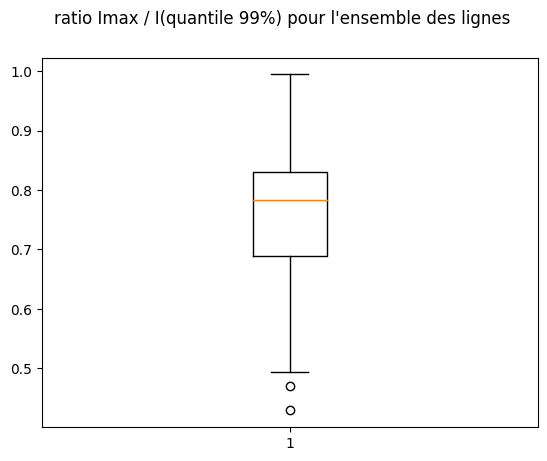

In [75]:
#HighVoltage=350
#LowVoltage=150

#get high voltage line to differentiate available margin (high voltage lines are often more expensive and developped closer to the need)
v_or=env.backend.v_or
v_ex=env.backend.v_ex
v=np.maximum(v_or,v_ex)

lines_high_voltage_immuned=[immuned_lines[i] for i in range(len(immuned_lines)) if v[i]>=high_voltage_threshold]

#with max
#immuned_ist = df_donothing[immuned_lines].max(axis=0) * MarginFactor_LowVoltage #more margin for lower voltage lines
#immuned_ist[lines_high_voltage_immuned] = df_donothing[lines_high_voltage_immuned].max(axis=0) * MarginFactor_HighVoltage #less margin in proportion for higher voltage lines

#with 99 percentile
immuned_ist = (df_donothing[immuned_lines].quantile(0.99,axis=0) * MarginFactor_LowVoltage).round() #more margin for lower voltage lines
immuned_ist[lines_high_voltage_immuned] = (df_donothing[lines_high_voltage_immuned].quantile(0.99,axis=0) * MarginFactor_HighVoltage).round() #less margin in proportion for higher voltage lines

# control the ratio .99 percentile vs max = 
ratio_max_99 = (df_donothing[immuned_lines].quantile(0.99,axis=0)/df_donothing[immuned_lines].max(axis=0))

# print(ratio_max_99.describe())
# ratio_max_99.to_csv("ratio_max_99.csv")

plt.figure()
plt.suptitle("ratio Imax / I(quantile 99%) pour l'ensemble des lignes")
plt.boxplot(ratio_max_99)
plt.show()


immuned_ist = np.ceil(immuned_ist + 1)


In [76]:
#saving thermal limits
df_old_thermal_limits = pd.DataFrame(columns=LINE_NAMES, index=['old_ist'], data = old_ist.reshape(1, -1))
df_thermal_limits=pd.DataFrame(pd.concat([selection_ist, immuned_ist])[LINE_NAMES]).transpose()
df_thermal_limits.to_csv(os.path.join(output_folder_v_calibration,output_file_th))
df_thermal_limits = pd.concat([df_old_thermal_limits, df_thermal_limits])

new_ist = df_thermal_limits.loc[0.99, :].values
df_thermal_limits


,0_1_0,0_2_1,10_11_2,69_70_3,23_71_4,70_71_5,70_72_6,69_73_7,69_74_8,68_74_9,73_74_10,75_76_11,68_76_12,1_11_13,74_76_14,76_77_15,77_78_16,76_79_17,76_79_18,78_79_19,76_81_20,81_82_21,82_83_22,82_84_23,2_11_24,83_84_25,84_85_26,84_87_27,84_88_28,87_88_29,88_89_30,88_89_31,89_90_32,88_91_33,88_91_34,6_11_35,90_91_36,91_92_37,91_93_38,92_93_39,93_94_40,79_95_41,81_95_42,93_95_43,79_96_44,79_97_45,10_12_46,79_98_47,91_99_48,93_99_49,94_95_50,95_96_51,97_99_52,98_99_53,99_100_54,91_101_55,100_101_56,11_13_57,99_102_58,99_103_59,102_103_60,102_104_61,99_105_62,103_104_63,104_105_64,104_106_65,104_107_66,105_106_67,12_14_68,107_108_69,102_109_70,108_109_71,109_110_72,109_111_73,16_112_74,31_112_75,31_113_76,26_114_77,113_114_78,13_14_79,11_116_80,74_117_81,75_117_82,11_15_83,14_16_84,3_4_85,15_16_86,16_17_87,17_18_88,18_19_89,14_18_90,19_20_91,20_21_92,21_22_93,22_23_94,22_24_95,2_4_96,24_26_97,26_27_98,27_28_99,7_29_100,25_29_101,16_30_102,28_30_103,22_31_104,30_31_105,26_31_106,4_5_107,14_32_108,18_33_109,34_35_110,34_36_111,32_36_112,33_35_113,33_36_114,36_38_115,36_39_116,29_37_117,5_6_118,38_39_119,39_40_120,39_41_121,40_41_122,42_43_123,33_42_124,43_44_125,44_45_126,45_46_127,45_47_128,7_8_129,46_48_130,41_48_131,41_48_132,44_48_133,47_48_134,48_49_135,48_50_136,50_51_137,51_52_138,52_53_139,8_9_140,48_53_141,48_53_142,53_54_143,53_55_144,54_55_145,55_56_146,49_56_147,55_57_148,50_57_149,53_58_150,3_10_151,55_58_152,55_58_153,54_58_154,58_59_155,58_60_156,59_60_157,59_61_158,60_61_159,62_63_160,37_64_161,4_10_162,63_64_163,48_65_164,48_65_165,61_65_166,61_66_167,65_66_168,46_68_169,48_68_170,68_69_171,23_69_172,7_4_173,25_24_174,80_79_175,86_85_176,115_67_177,29_16_178,37_36_179,62_58_180,63_60_181,64_65_182,64_67_183,67_68_184,80_67_185
old_ist,233.399994,354.399994,792.700012,550.200012,572.200012,557.200012,8.0,480.0,567.400024,681.799988,357.600006,336.899994,819.0,419.200012,304.200012,626.200012,256.100006,300.100006,132.699997,165.899994,841.0,1105.5,428.200012,555.200012,224.199997,374.399994,285.600006,429.799988,253.100006,479.600006,238.300003,452.600006,312.899994,627.799988,196.100006,360.899994,317.100006,325.100006,352.600006,347.299988,565.5,495.700012,1422.900024,479.799988,646.900024,1603.900024,364.100006,1498.400024,278.0,866.200012,1667.699951,569.599976,1350.199951,1478.0,380.799988,282.399994,246.899994,301.299988,766.900024,401.200012,306.899994,314.399994,333.399994,748.900024,513.400024,255.800003,513.0,268.5,219.0,492.0,420.399994,417.399994,637.799988,571.900024,593.799988,273.700012,247.0,385.299988,283.399994,251.199997,210.800003,473.899994,408.5,162.699997,602.200012,1098.599976,205.0,546.0,435.899994,191.399994,424.100006,106.199997,149.199997,184.899994,1146.099976,1117.800049,569.599976,800.200012,380.299988,292.100006,636.5,487.5,490.899994,207.399994,590.599976,243.800003,466.0,698.200012,385.0,351.700012,60.900002,231.899994,340.799988,212.800003,749.200012,332.399994,348.0,798.0,398.299988,414.399994,341.100006,371.399994,401.200012,298.299988,343.299988,267.799988,213.899994,160.800003,112.199997,458.899994,349.700012,489.0,489.0,180.699997,196.699997,191.899994,238.399994,174.199997,105.599998,143.699997,393.600006,293.399994,288.899994,107.699997,623.200012,252.899994,118.300003,154.399994,111.699997,106.5,177.5,655.799988,161.199997,169.300003,120.699997,389.299988,291.200012,592.099976,277.0,412.200012,441.0,671.200012,609.0,867.400024,494.600006,494.600006,196.699997,167.0,263.399994,364.100006,359.700012,803.200012,589.0,887.200012,615.200012,1096.800049,306.899994,472.600006,546.599976,370.5,441.0,300.299988,656.200012,1346.0,1246.5,1196.5
0.99,349.000000,546.000000,1151.000000,581.000000,743.000000,613.000000,69.0,801.0,731.000000,953.000000,463.000000,291.000000,730.0,649.000000,461.000000,916.000000,281.000000,146.000000,69.000000,251.000000,1901.0,1356.0,601.000000,793.000000,351.000000,509.000000,409.000000,566.000000,339.000000,899.000000,356.000000,673.000000,543.000000,131

Text(0.5, 1.0, 'compare newly calibrated thermal limits to the ones that could already exist in the environment')

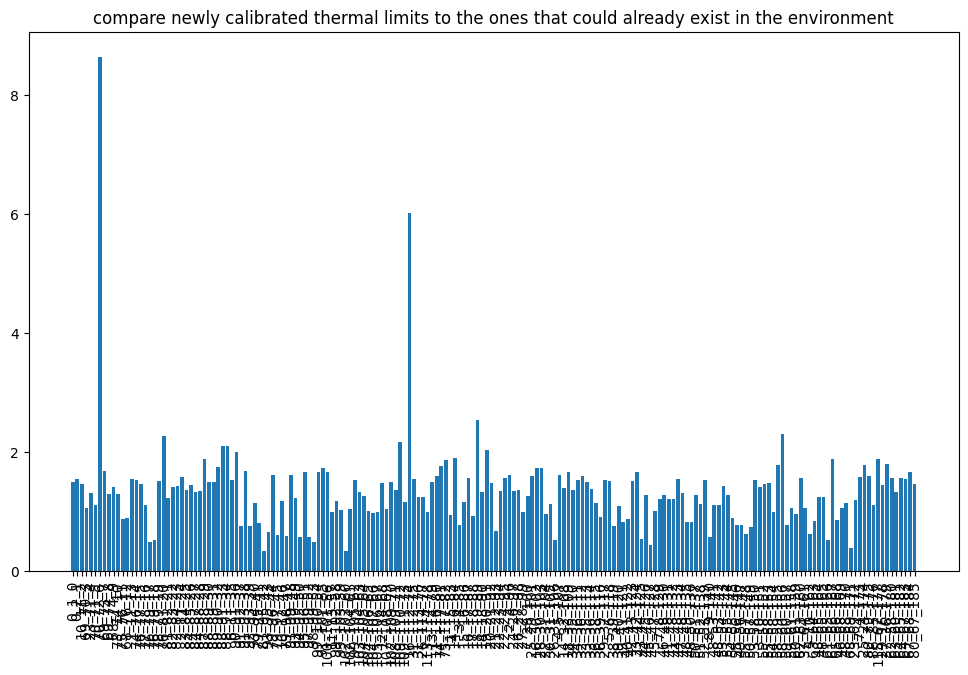

In [77]:
plt.figure(figsize=(12, 7))
plt.xticks(rotation=90)
plt.bar(LINE_NAMES, height=new_ist / old_ist)
plt.title("compare newly calibrated thermal limits to the ones that could already exist in the environment")

<BarContainer object of 25 artists>

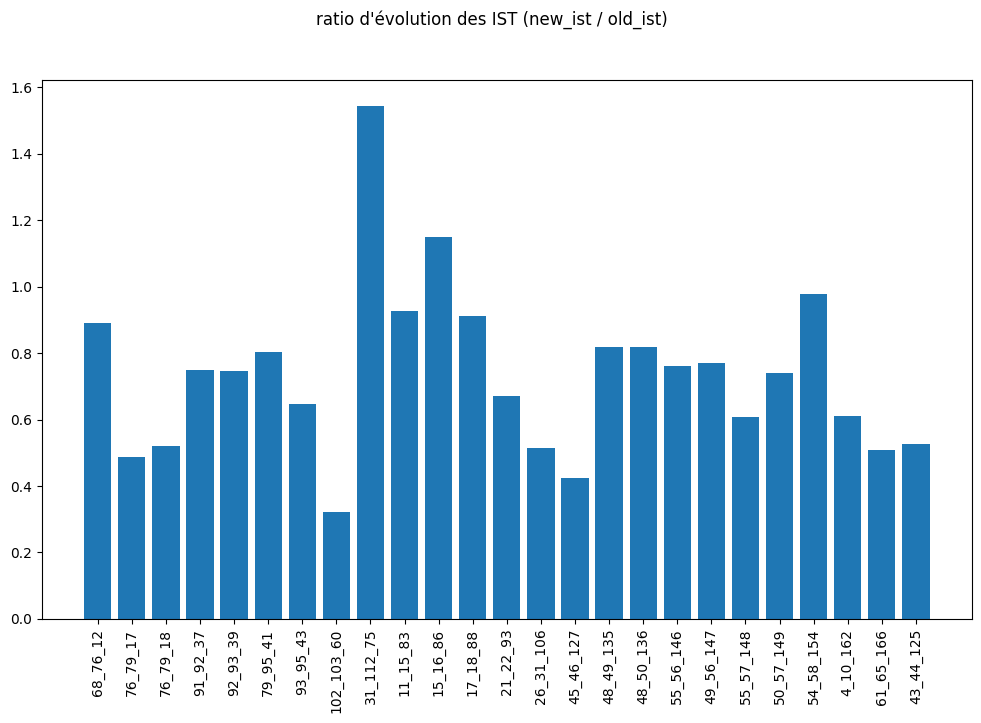

In [98]:
lines_overload=LINE_NAMES[proposed_overloads]
overload_difference_ratio=(new_ist / old_ist)[proposed_overloads]
plt.figure(figsize=(12, 7))
plt.suptitle("ratio d'évolution des IST (new_ist / old_ist)")
plt.xticks(rotation=90)
plt.bar(lines_overload, height=overload_difference_ratio)

# Analyse sur la grille de base sans modifications topologiques

In [79]:
df_istratio = df_donothing[lines_overload] / new_ist[proposed_overloads].reshape(1,-1) 
df_overload = 1.* (df_istratio >= 1)
df_overload.describe()

,68_76_12,76_79_17,76_79_18,91_92_37,92_93_39,79_95_41,93_95_43,102_103_60,31_112_75,11_15_83,15_16_86,17_18_88,21_22_93,26_31_106,45_46_127,48_49_135,48_50_136,55_56_146,49_56_147,55_57_148,50_57_149,54_58_154,4_10_162,61_65_166,43_44_125
count,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000,524680.000000
mean,0.009840,0.009596,0.009549,0.009270,0.009537,0.009705,0.009918,0.009953,0.009579,0.009680,0.009541,0.009838,0.008958,0.009526,0.009917,0.009013,0.009762,0.009505,0.009208,0.009924,0.009463,0.008483,0.009697,0.009593,0.009610
std,0.098709,0.097490,0.097250,0.095836,0.097192,0.098035,0.099096,0.099266,0.097403,0.097911,0.097211,0.098700,0.094221,0.097134,0.099087,0.094509,0.098320,0.097028,0.095513,0.099125,0.096816,0.091713,0.097997,0.097471,0.097557
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


average percentage each line is overloaded over time
0.9546618891514826


,68_76_12,76_79_17,76_79_18,91_92_37,92_93_39,79_95_41,93_95_43,102_103_60,31_112_75,11_15_83,15_16_86,17_18_88,21_22_93,26_31_106,45_46_127,48_49_135,48_50_136,55_56_146,49_56_147,55_57_148,50_57_149,54_58_154,4_10_162,61_65_166,43_44_125
0,0.984028,0.959633,0.954868,0.927041,0.953724,0.970496,0.991843,0.995273,0.957917,0.968019,0.954105,0.983838,0.895784,0.952581,0.991652,0.901311,0.976214,0.950484,0.920752,0.992414,0.946291,0.848327,0.969734,0.959251,0.960967


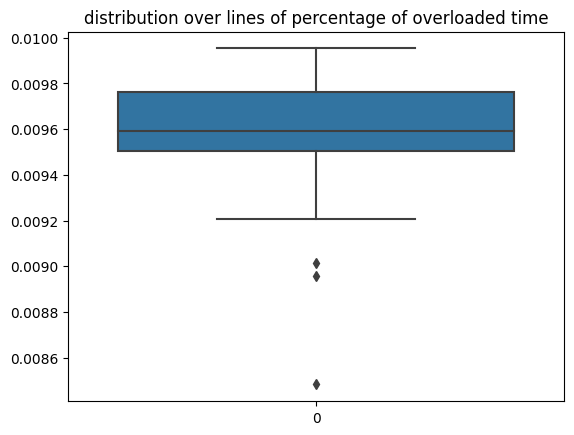

In [80]:
print("average percentage each line is overloaded over time")
overall_mean_overloaded_time_percentage_per_line=df_overload.mean().mean()*100
print(overall_mean_overloaded_time_percentage_per_line)

sns.boxplot(df_overload.mean()).set_title("distribution over lines of percentage of overloaded time")

df_percentageOverload_lines=pd.DataFrame(df_overload.mean()*100).transpose()
df_percentageOverload_lines

# Check the calibration

Some criteria can mostly be met at the time of choosing lines to overload. 
Now it is more about setting the right level of difficulty than looking for diversity 

Here we define some "KPI" to meet for the calibration, this includes:
%- we should have overflow pretty much all the year
%- we should have overflow all day of the week
%- we should have overflow all hour of the day
- we should not have more than 10% of days with overflow
%- we should have overflow due to:
%    - high loads
%    - high solar
%    - high wind

In [81]:
df_istratio.max(axis=0) 

68_76_12      1.338356
76_79_17      1.842466
76_79_18      1.840580
91_92_37      1.270492
92_93_39      1.332046
79_95_41      1.484925
93_95_43      1.723473
102_103_60    1.232323
31_112_75     1.217494
11_15_83      1.470199
15_16_86      1.326271
17_18_88      1.168766
21_22_93      1.475806
26_31_106     1.229167
45_46_127     1.338235
48_49_135     1.229299
48_50_136     1.241026
55_56_146     1.344444
49_56_147     1.277311
55_57_148     1.720588
50_57_149     1.316456
54_58_154     1.203390
4_10_162      1.193548
61_65_166     1.330000
43_44_125     1.382979
dtype: float64

In [82]:
# not useful here, it should matter when choosing lines to overload

#import warnings
#warnings.filterwarnings('ignore')
#
#from utils.generate_visus import plot_month_day_hour_dist
#
#df_istratio["month"]=df["month"]
#df_istratio["hour_of_day"]=df["hour_of_day"]
#df_istratio["day_of_week"]=df["day_of_week"]
#plot_month_day_hour_dist(df_istratio, factors=lines_overload)


In [83]:
df_ovld_10 = pd.DataFrame({
    col : pd.concat([df_overload[[col]].shift(periods=-i, fill_value=0) for i in range(10)],axis=1).sum(axis=1)for col in LINE_NAMES[proposed_overloads]
}) / 10
df_ovld_25 = pd.DataFrame({
    col : pd.concat([df_overload[[col]].shift(periods=-i, fill_value=0) for i in range(25)],axis=1).sum(axis=1)for col in LINE_NAMES[proposed_overloads]
}) /25
df_ovld_37 = pd.DataFrame({
    col : pd.concat([df_overload[[col]].shift(periods=-i, fill_value=0) for i in range(25)],axis=1).sum(axis=1)for col in LINE_NAMES[proposed_overloads]
}) /37
df_ovld_10.head()

,68_76_12,76_79_17,76_79_18,91_92_37,92_93_39,79_95_41,93_95_43,102_103_60,31_112_75,11_15_83,15_16_86,17_18_88,21_22_93,26_31_106,45_46_127,48_49_135,48_50_136,55_56_146,49_56_147,55_57_148,50_57_149,54_58_154,4_10_162,61_65_166,43_44_125
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.0,0.0


In [84]:
nb_ovld = df_overload[LINE_NAMES[proposed_overloads]].sum(axis=0) 
nb_ovld / df_overload.shape[0] * 100 #percentage of time that lines are overloaded 

68_76_12      0.984028
76_79_17      0.959633
76_79_18      0.954868
91_92_37      0.927041
92_93_39      0.953724
79_95_41      0.970496
93_95_43      0.991843
102_103_60    0.995273
31_112_75     0.957917
11_15_83      0.968019
15_16_86      0.954105
17_18_88      0.983838
21_22_93      0.895784
26_31_106     0.952581
45_46_127     0.991652
48_49_135     0.901311
48_50_136     0.976214
55_56_146     0.950484
49_56_147     0.920752
55_57_148     0.992414
50_57_149     0.946291
54_58_154     0.848327
4_10_162      0.969734
61_65_166     0.959251
43_44_125     0.960967
dtype: float64

In [85]:
(df_ovld_10 >= 1).sum(axis=0) / nb_ovld *100

68_76_12      65.775712
76_79_17      46.077458
76_79_18      45.868263
91_92_37      50.555099
92_93_39      58.453237
79_95_41      66.280440
93_95_43      64.546503
102_103_60    46.840291
31_112_75     63.390370
11_15_83      49.497933
15_16_86      51.837795
17_18_88      73.169314
21_22_93      32.744681
26_31_106     58.403361
45_46_127     61.675956
48_49_135     39.120321
48_50_136     38.559157
55_56_146     38.560257
49_56_147     38.211550
55_57_148     48.396389
50_57_149     39.073515
54_58_154     44.798922
4_10_162      33.667453
61_65_166     66.977946
43_44_125     58.032527
dtype: float64

In [86]:
(df_ovld_25 >= 1).sum(axis=0) / nb_ovld *100

68_76_12      39.686229
76_79_17      15.273088
76_79_18      14.990020
91_92_37      21.936678
92_93_39      32.234213
79_95_41      37.804399
93_95_43      36.471945
102_103_60    16.315588
31_112_75     35.137286
11_15_83      17.089978
15_16_86      19.736316
17_18_88      45.873692
21_22_93      12.893617
26_31_106     30.372149
45_46_127     31.693254
48_49_135     10.340453
48_50_136     10.074190
55_56_146     12.231803
49_56_147     10.888015
55_57_148     21.739965
50_57_149     12.245720
54_58_154     14.805662
4_10_162       7.841981
61_65_166     38.644943
43_44_125     28.103927
dtype: float64

In [87]:
(df_ovld_37 >= 1).sum(axis=0) 

68_76_12      0
76_79_17      0
76_79_18      0
91_92_37      0
92_93_39      0
79_95_41      0
93_95_43      0
102_103_60    0
31_112_75     0
11_15_83      0
15_16_86      0
17_18_88      0
21_22_93      0
26_31_106     0
45_46_127     0
48_49_135     0
48_50_136     0
55_56_146     0
49_56_147     0
55_57_148     0
50_57_149     0
54_58_154     0
4_10_162      0
61_65_166     0
43_44_125     0
dtype: int64

# Generate best agent and overload dataframe

## ligther df_analysis 
Given that we know the number overload at each timesteps, for each agent, we will take the best of all agents at each time step to identify what could have been the best configuration with least overloads. The result will be a "best_agent". We can then only keep the "do_nothing" agent and "best_agent" for a more straightforward analysis


In [88]:
from utils.Overload import get_simple_overload_df

thermal_limits=new_ist

Overloads_df=get_simple_overload_df(df,LINE_NAMES,proposed_overloads,thermal_limits)
Overloads_df.max_depth=Overloads_df.max_depth.astype("float32") #because sort values does not deal with float16


computing for line 68_76_12
computing for line 76_79_17
computing for line 76_79_18
computing for line 91_92_37
computing for line 92_93_39
computing for line 79_95_41
computing for line 93_95_43
computing for line 102_103_60
computing for line 31_112_75
computing for line 11_15_83
computing for line 15_16_86
computing for line 17_18_88
computing for line 21_22_93
computing for line 26_31_106
computing for line 45_46_127
computing for line 48_49_135
computing for line 48_50_136
computing for line 55_56_146
computing for line 49_56_147
computing for line 55_57_148
computing for line 50_57_149
computing for line 54_58_154
computing for line 4_10_162
computing for line 61_65_166
computing for line 43_44_125
finish nb total
finish max rhos


In [89]:
best_df=Overloads_df.sort_values(['nb_total','max_depth'], ascending=True).drop_duplicates(['scenario','datetimes'])
#ascending=[True, False]
df_analysis_light=df.loc[best_df.index,:]
df_analysis_light["agent"]="best_agent"

#df_analysis_light=df_analysis_light.append(df_analysis[df_analysis.agent=="do_nothing"]).reset_index(drop=True)
df_analysis_light=pd.concat([df_analysis_light,df[df.agent=="do_nothing"]],ignore_index=True)
df_analysis_light=df_analysis_light.sort_values(['agent','scenario','datetimes'], ascending=True,ignore_index=True)
    
df_analysis_light_file_path=os.path.join(output_folder_v_calibration,output_file_flow_light)
df_analysis_light.to_feather(df_analysis_light_file_path)

## best_agent overload info

#### check that scenarios are continuous in the indices of the resultating dataframe. Otherwise reorder
This is needed for the get_overload_info_df method to run properly

In [97]:

Overloads=(df_analysis_light[LINE_NAMES]>= thermal_limits).astype('bool')
Overloads['scenario']=df_analysis_light['scenario']

Overloads_best_agent=Overloads[df_analysis_light.agent=="best_agent"]
Overloads_best_agent.head()


def first(df):
    return df.index[0]

def last(df):
    return df.index[-1]

firstLastIndices=pd.concat([Overloads_best_agent.groupby('scenario').apply(first),Overloads_best_agent.groupby('scenario').apply(last)],axis=1)
firstLastIndices.head(10)

,0,1
scenario,,
2035-01-01_0,0,2017
2035-01-01_1,2018,4035
2035-01-01_2,4036,6053
2035-01-01_3,6054,8071
2035-01-01_4,8072,10089
2035-01-08_0,10090,12107
2035-01-08_1,12108,14125
2035-01-08_2,14126,16143
2035-01-08_3,16144,18161


In [91]:
from utils.Overload import get_overload_info_df
#overload_best_agent_file_path=os.path.join(output_folder_v_calibration,ouput_file_ov_df)

overloads_info_best_agent=get_overload_info_df(df_analysis_light,LINE_NAMES,thermal_limits,proposed_overloads, verbose=True)
print("saving file in: "+ input_file_ov_lines_path)
overloads_info_best_agent.to_feather(os.path.join(output_folder_v_calibration,output_file_ov_df))

overloads_info_best_agent.head(10)

overload created
best_agent
do_nothing
Dataframe generated!!
Time taken = 0.9486520290374756 seconds
saving file in: Outputs/l2rpn_idf_2023_v4_20pc/v0\lines_to_overload.csv


,scenarios,agent,start_indices,end_indices,duration,maxDepth_indices,maxDepths,hour_of_day,day_of_week,month,day_of_year,datetimes,overload_line_name
0,2035-01-01_1,best_agent,1371,1386,15,1383,1.240234,19,4,1,5,2035-01-05 19:10:00,68_76_12
1,2035-01-08_0,best_agent,1850,1857,7,1852,1.019531,10,6,1,14,2035-01-14 10:15:00,68_76_12
2,2035-01-08_0,best_agent,1872,1889,17,1885,1.089844,13,6,1,14,2035-01-14 13:00:00,68_76_12
3,2035-01-08_1,best_agent,1090,1091,1,1090,1.009766,18,3,1,11,2035-01-11 18:45:00,68_76_12
4,2035-01-08_1,best_agent,1098,1100,2,1098,1.089844,19,3,1,11,2035-01-11 19:25:00,68_76_12
5,2035-01-08_1,best_agent,1103,1105,2,1103,1.040039,19,3,1,11,2035-01-11 19:50:00,68_76_12
6,2035-01-08_1,best_agent,1255,1256,1,1255,1.030273,8,4,1,12,2035-01-12 08:30:00,68_76_12
7,2035-01-08_1,best_agent,1330,1336,6,1330,1.009766,14,4,1,12,2035-01-12 14:45:00,68_76_12
8,2035-01-08_1,best_agent,1337,1338,1,1337,1.009766,15,4,1,12,2035-01-12 15:20:00,68_76_12
9,2035-01-08_1,best_agent,1429,1432,3,1431,1.009766,23,4,1,12,2035-01-12 23:10:00,68_76_12


Check that "best_agent" reduces the number of overload and their max depth

In [92]:
percentage_reduced=np.round(1-(best_df["nb_total"].sum()/Overloads_df.loc[Overloads_df.agent=="do_nothing","nb_total"].sum()),2)*100
print("the percentage of overload decrease with considered actions is: "+str(percentage_reduced))

the percentage of overload decrease with considered actions is: 62.0


Text(0.5, 1.0, 'with do nothing agent')

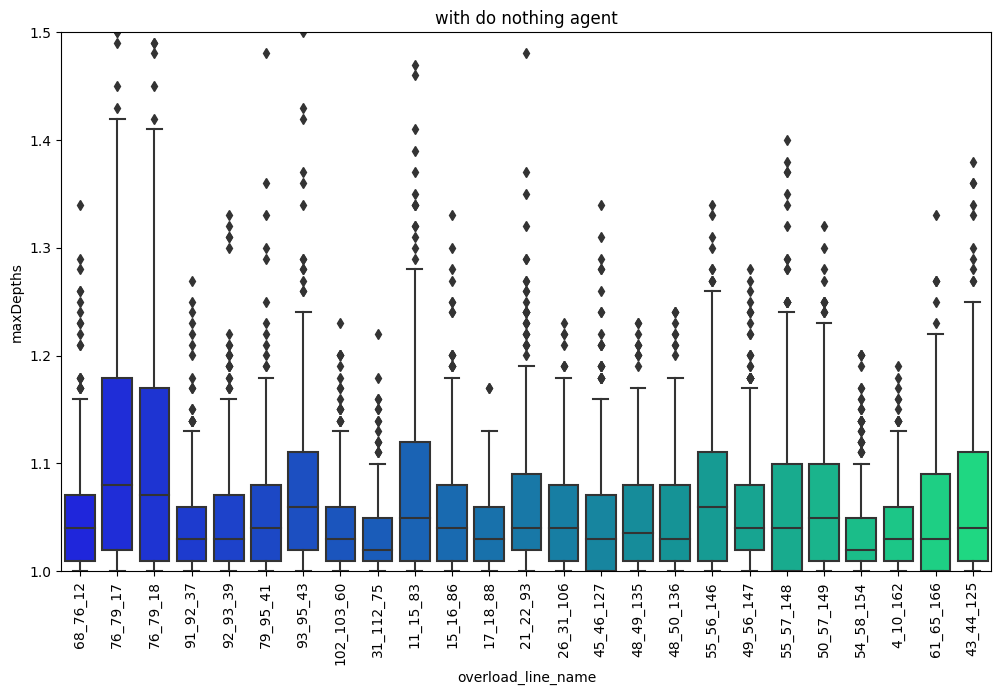

In [93]:
plt.figure(figsize=(12, 7))
plt.xticks(rotation=90)
plt.ylim(1, 1.5)
sns.boxplot(x='overload_line_name', y='maxDepths', data=overloads_info_best_agent[overloads_info_best_agent.agent=="do_nothing"], 
            palette='winter').set_title("with do nothing agent")

Text(0.5, 1.0, 'with best agent')

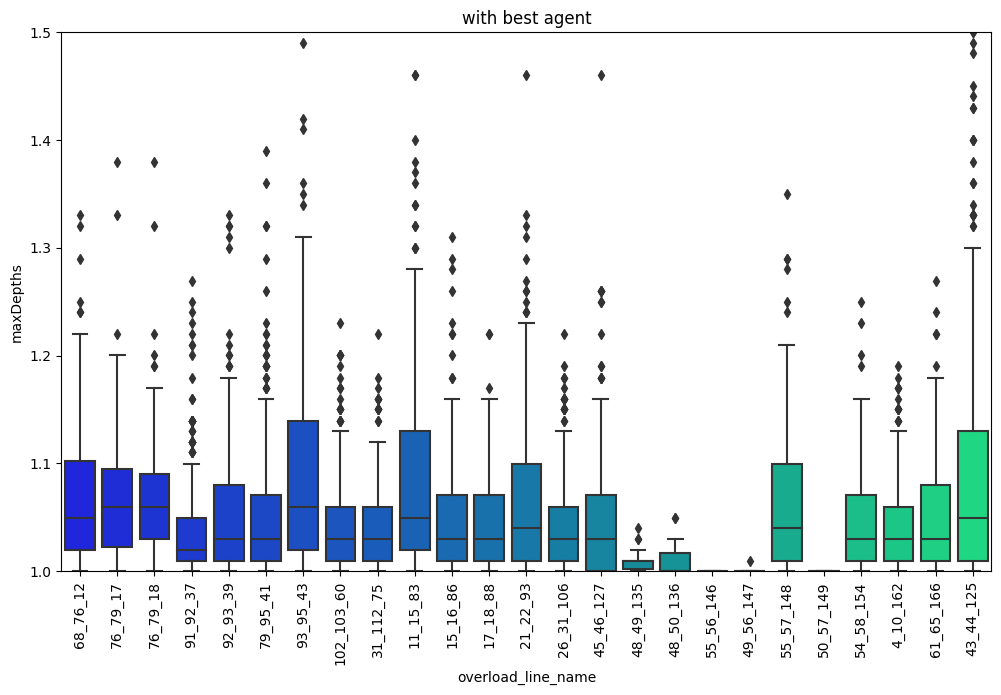

In [94]:
plt.figure(figsize=(12, 7))
plt.xticks(rotation=90)
plt.ylim(1, 1.5)
sns.boxplot(x='overload_line_name', y='maxDepths', data=overloads_info_best_agent[overloads_info_best_agent.agent=="best_agent"], 
            palette='winter').set_title("with best agent")